In [1]:
# ガブリエル比較区間を求めるのに必要なやつ
import numpy as np
import pandas as pd
import math
from scipy import stats, integrate, optimize

# そのた(描画 + R実行用)
import matplotlib.pyplot as plt
import pyper

In [2]:
def calc_gabriel_by_R(val, category, alpha=0.05):
    r = pyper.R()
    r('library(rgabriel)')
    r.assign('val', val)
    r.assign('category', category)
    r.assign('alpha', alpha)
    errs = r.get('rgabriel(val, category, alpha)')
    return errs

In [3]:
# pythonでガブリエル比較区間を出す
def psmm_x(x, c, r, nu):
    #c = c[0]
    snu = math.sqrt(nu)
    sx = snu * x # for the scaled Chi distribution
    lgx = math.log(snu) - math.lgamma(nu/2) +\
            (1 - nu/2) * math.log(2) + (nu - 1) * math.log(sx) + (-pow(sx, 2) /2)
    return math.exp(r * math.log(2 * stats.norm.cdf(c * x) - 1) + lgx)

def psmm(x, r, nu):
    return integrate.quad(lambda x_: psmm_x(x_, c=x, r=r, nu=nu), 0, np.inf)[0]

def qsmm(q, r, nu):
    r = r * (r - 1) / 2
    if nu is None:
        return stats.norm.ppf(1 - .5 * (1 - pow(q, (1 / r))))
    fx = lambda c: psmm(c, r, nu) - q
    return optimize.bisect(fx, 1e-8, 100)

def gabriel(x, f, a=0.05):
    data = pd.DataFrame({
        'val': x,
        'cat': f
    }).dropna()
    stds = data.groupby('cat').std()
    nums = data.groupby('cat').count()
    dfs = nums - 1 #自由度
    dfstar = dfs.sum().values[0]

    sr = qsmm(1-a, len(np.unique(f)), dfstar)
    return sr * stds / np.sqrt(2 * nums)

## 信頼区間は重なるけどガブリエル比較区間は重ならない、実はデータに有意差があるパターン
参考: http://uncorrelated.hatenablog.com/entry/2019/04/09/103023

In [4]:
data = pd.DataFrame({
    'cat': ["C","C","C","C","C","C","T-1","T-1","T-1","T-1","T-1","T-1"],
    'val': [0.117,-0.718,0.7199,-0.2422,-0.3391,-0.2223,1.0094,1.4306,0.099,1.2839,0.403,0.5616]
})

In [5]:
data.columns

Index(['cat', 'val'], dtype='object')

In [6]:
errs_gabriel_r = calc_gabriel_by_R(data['val'].values, data['cat'].values)
errs_gabriel_py = gabriel(data['val'].values, data['cat'].values, a=0.05)

In [7]:
x = []
y = []
y_err = []
names = []

for i, (name, df_part) in enumerate(data.groupby('cat')):
    val = df_part['val'].values
    lower, upper = stats.t.interval(
        alpha=0.95,
        loc=val.mean(),
        scale=np.sqrt(val.var() / len(val)),
        df=len(val) - 1
    )
    err = (upper - lower) / 2
    x.append(i)
    y.append(val.mean())
    y_err.append(err)
    names.append(name)


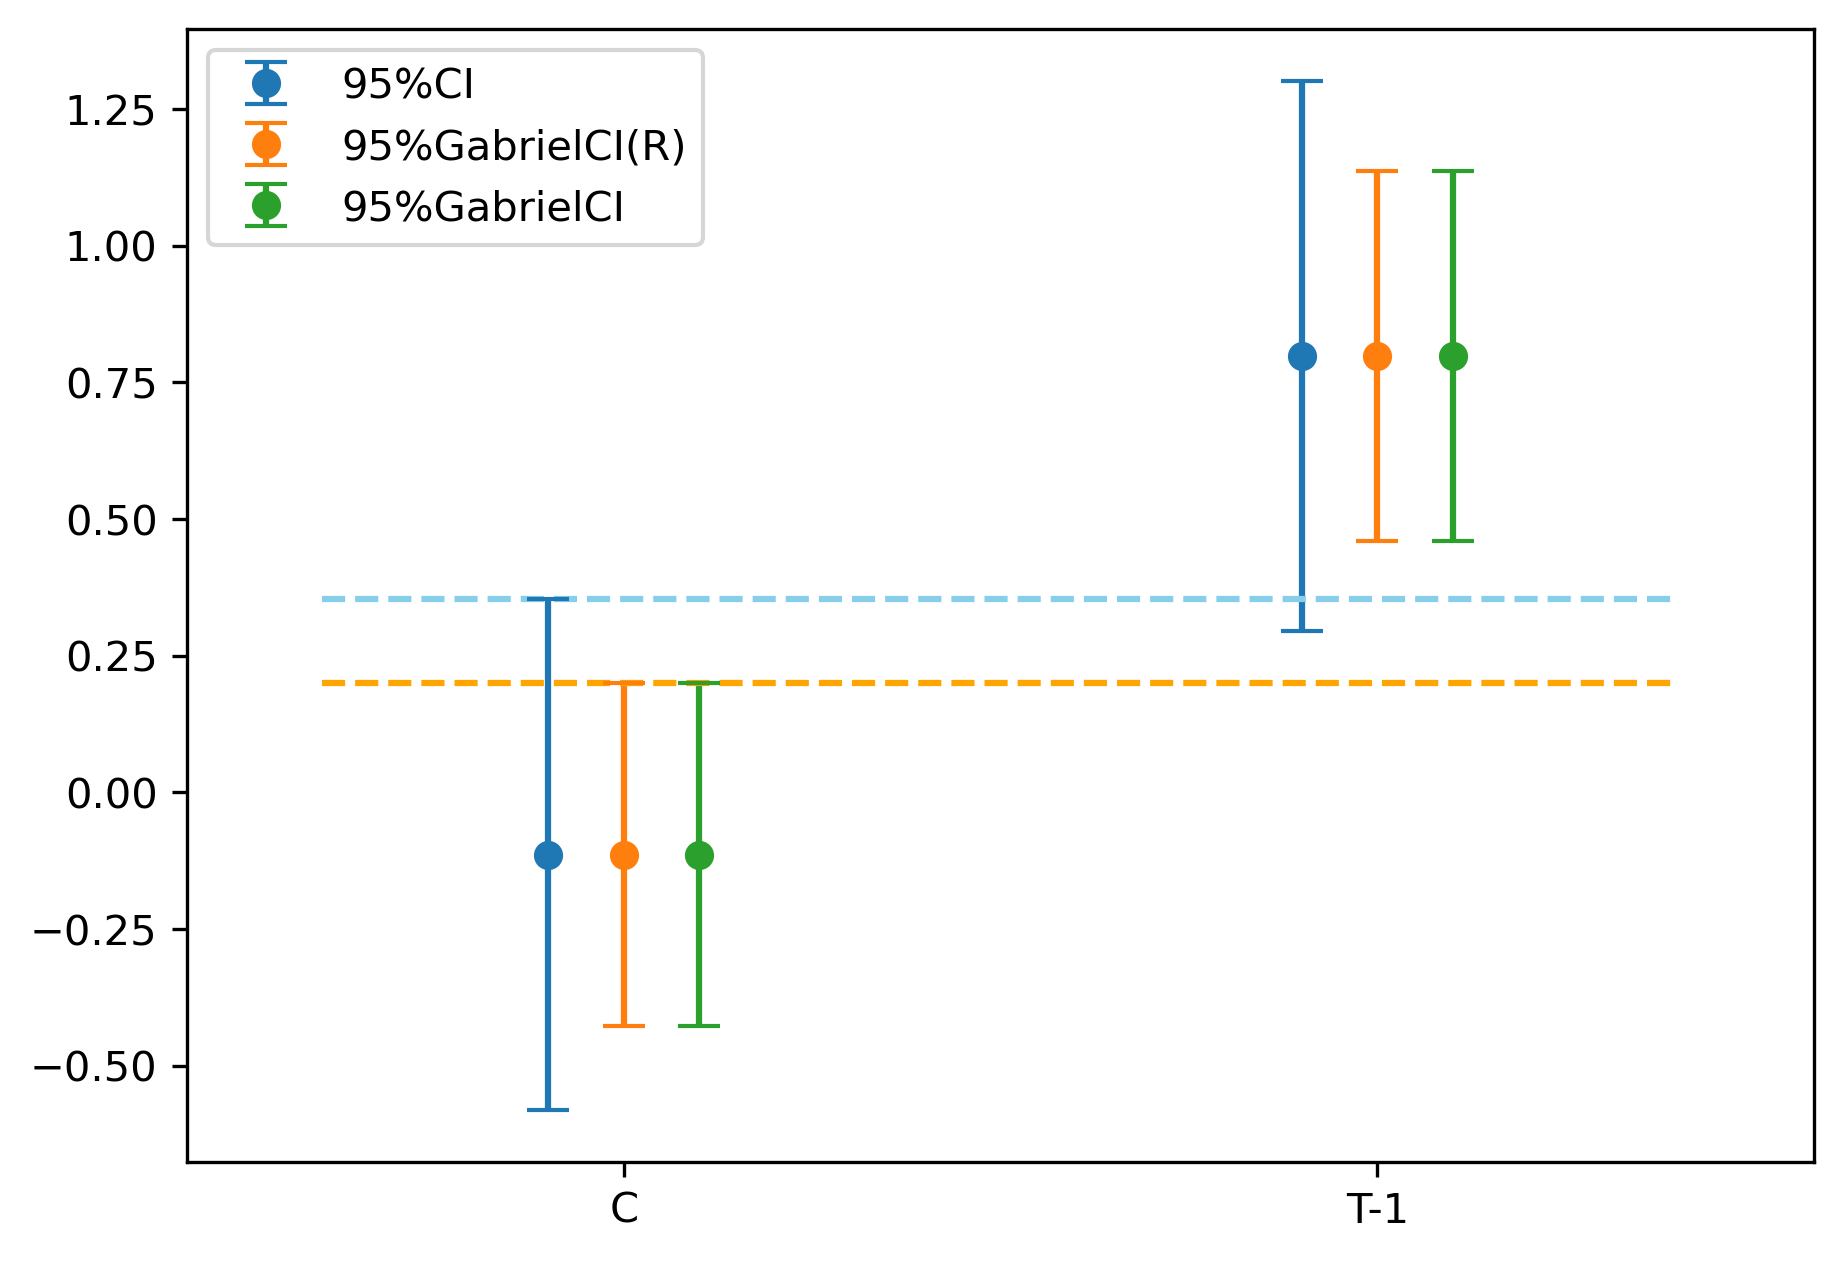

In [8]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
ax.errorbar(np.array(x) - 0.1, y, yerr=y_err, capsize=5, fmt='o', linestyle='None', label='95%CI')
ax.errorbar(np.array(x), y, yerr=errs_gabriel_r, capsize=5, fmt='o', linestyle='None', label='95%GabrielCI(R)')
ax.errorbar(np.array(x) + 0.1, y, yerr=errs_gabriel_py['val'].values, capsize=5, fmt='o', linestyle='None', label='95%GabrielCI')
ax.legend()
ax.margins(x=0.1)
ax.set_xticks(x)
ax.set_xticklabels(names)
# 補助線ひく
# cat=Cの95%CI上限値
ax.hlines(y[0] + y_err[0], xmin=-0.4, xmax=1.4, linestyle='dashed', color='skyblue')
# cat=Cの95%ガブリエル比較区間上限値
ax.hlines(y[0] + errs_gabriel_py['val'].values[0], xmin=-0.4, xmax=1.4, linestyle='dashed', color='orange');

## カテゴリがたくさんあるパターン(多重比較)

In [9]:
# seedを固定せず一様分布の乱数を10個ずつ10回抽出する
all_data = []
for cat in 'ABCDEFGHIJ':
    data = pd.DataFrame(np.random.rand(10), columns=['val'])
    data['category'] = cat
    all_data.append(data)
data = pd.concat(all_data, axis=0)

In [10]:
errs_gabriel_r = calc_gabriel_by_R(data['val'].values, data['category'].values)

In [11]:
errs_gabriel_py = gabriel(data['val'].values, data['category'].values, a=0.05)

In [12]:
x = []
y = []
y_err = []
names = []

for i, (name, df_part) in enumerate(data.groupby('category')):
    val = df_part['val'].values
    lower, upper = stats.t.interval(
        alpha=0.95,
        loc=val.mean(),
        scale=np.sqrt(val.var() / len(val)),
        df=len(val) - 1
    )
    err = (upper - lower) / 2
    x.append(i)
    y.append(val.mean())
    y_err.append(err)
    names.append(name)


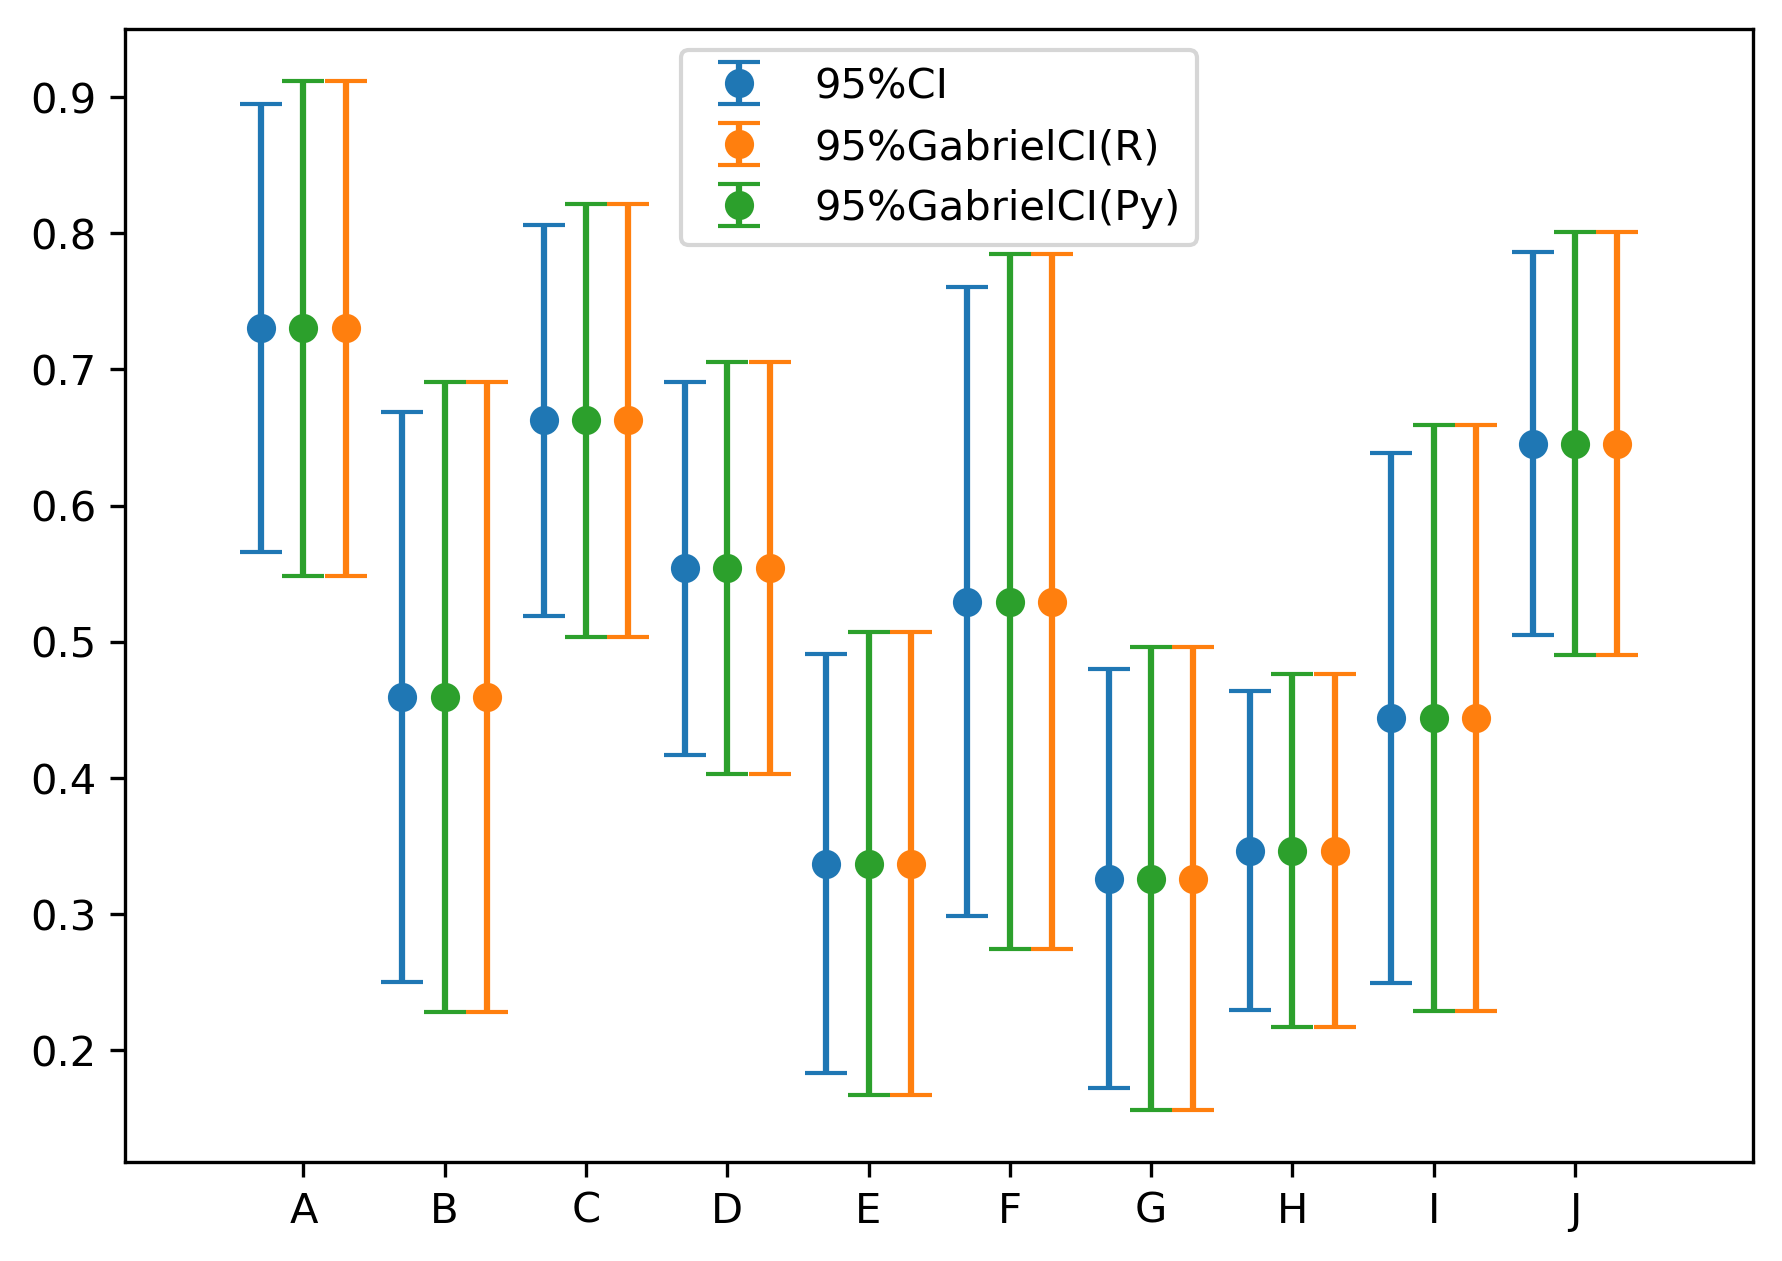

In [13]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
ax.errorbar(np.array(x) - 0.3, y, yerr=y_err, capsize=5, fmt='o', linestyle='None', label='95%CI')
ax.errorbar(np.array(x) + 0.3, y, yerr=errs_gabriel_r, capsize=5, fmt='o', linestyle='None', label='95%GabrielCI(R)')
ax.errorbar(np.array(x), y, yerr=errs_gabriel_py['val'].values, capsize=5, fmt='o', linestyle='None', label='95%GabrielCI(Py)')
ax.legend()
ax.margins(x=0.1)
ax.set_xticks(x)
ax.set_xticklabels(names);